This notebook demonstrates how to use astrodust for predicting dust densities at a future point in time given an initial set of parameters and initial distribution. It assumes 171 dust bins.

In [1]:
!pip install astrodust
import numpy as np
import astrodust

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 166.7 MB 44 kB/s s eta 0:00:01   |▉                               | 4.4 MB 10.0 MB/s eta 0:00:17
     |████████████████████████████████| 303 kB 112.1 MB/s eta 0:00:01


Pick a model and an input/output combination to make a prediction from.

In [2]:
import os
import json
from scipy.spatial.distance import jensenshannon
from matplotlib import pyplot as plt

version = "v2"
filename = "/scratch/keh4nb/dust_training_data_all_bins_v2.csv"
root_data_path = f"/project/SDS-capstones-kropko21/dust_models/dust_coag_{version}"

data_set = "02455"
data_dir = f"{root_data_path}/data_{data_set}"
input_params = None

# Open and extract the input parameters
with open(os.path.join(root_data_path, f"model_dict_{version}.json")) as f:
    model_dict = json.load(f)
    input_dict = model_dict[data_set]

try:
    # `rho_dat`: The dust mass density (in g/cm^3) in each particle size/bin at a given snapshot in time. This is the main "output", i.e., the primary result, of any given model.
    rhod = np.loadtxt(os.path.join(data_dir,"rho_d.dat"))
    # Replace NaNs with 0s
    rhod = np.nan_to_num(rhod)
    # Replace negative values with 0s
    rhod = np.where(rhod<0, 0, rhod) 

     # `a_grid.dat`: The dust particle size in each "bin" in centimeters.
    a_grid = np.loadtxt(os.path.join(data_dir, 'a_grid.dat'))

    # `time.dat`: The time of each snapshot (in seconds).
    time = np.loadtxt(os.path.join(data_dir, "time.dat"))
except Exception as e:
    #print(f'model {d} skipped')
    import traceback
    print(traceback.print_exc())

input_idx = 0
output_idx = 10

input_bins = rhod[input_idx]
output_bins = rhod[output_idx]

t = time[input_idx]

# Difference of time in seconds between two snapshots
delta_t = time[output_idx] - t




Use astrodust to make a prediction

In [ ]:

from timeit import default_timer as timer
from astrodust import DustModel
start = timer()
model = DustModel()
pred_output = model.predict(input_dict['R'], input_dict['alpha'], input_dict['d2g'], input_dict['sigma'], input_dict['Tgas'], t, delta_t, input_bins)

end = timer()
print(f"Total time taken for 1 prediction: {end-start}.")

The random forest model file was not found in the model directory and must be downloaded (6.6GB). Are you sure you want to download it?
(Y) for yes or any other key to quit. Y


models/rf-model-large.joblib: 100%|##########| 6.68G/6.68G [21:18<00:00, 5.22MB/s] 


Plot the results between the prediction and the simulated output

(2, 171)
{'tag': '09816', 'R': 439.38752621208494, 'Mstar': 1.0, 'alpha': 0.01, 'd2g': 0.001, 'sigma': 0.18457689506039313, 'Tgas': 4.7706344303819845, 'm_min': 1e-15, 'm_max': 100.0, 'input': 'data/input_09816.nml', 'data': 'data'}


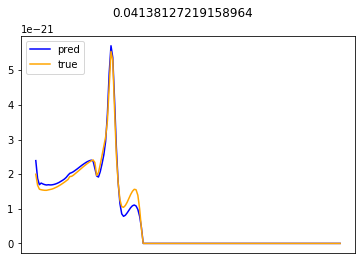

In [61]:
output_bins_n = output_bins.flatten()
fig = plt.figure()

print(pred_output.shape)
plt.plot(pred_output[1], color='blue', label='pred')
plt.plot(output_bins_n, color='orange', label='true')
plt.xticks([])
plt.legend(loc="upper left")

# Show the associated Jensen Shannon divergence
jc = jensenshannon(pred_output[1], output_bins_n.flatten())
fig.suptitle(jc)
#plt.show()

print(input_dict)


Have the model make predictions from previous output.

In [150]:
idxs = [0, 10, 20, 30, 40, 51]
pred_outputs = []
for i in range(1, 6):
    prev_idx = idxs[i-1]
    idx = idxs[i]
    if i == 1:
        input_bins = rhod[0]
    else:
        input_bins = pred_output

    t = time[prev_idx]

    # Difference of time in seconds between two snapshots
    delta_t = time[idx] - t

    pred_output = model.predict(input_dict['R'], input_dict['alpha'],input_dict['d2g'], input_dict['sigma'], input_dict['Tgas'], t, delta_t, input_bins)
    pred_outputs.append(pred_output)


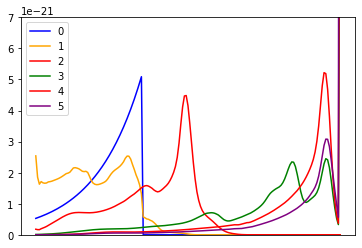

In [151]:
fig = plt.figure()
colors = ['orange', 'red', 'green', 'red', 'purple']
plt.plot(rhod[0], color='blue', label='0')
for idx, pred in enumerate(pred_outputs):
    plt.plot(pred, color=colors[idx], label=idx+1)
plt.xticks([])
plt.ylim(0, 7e-21) 
plt.legend(loc="upper left")
plt.show()

Display the predictions of the random forest model compared to the simulation

In [217]:
import os
import json
from scipy.spatial.distance import jensenshannon
from matplotlib import pyplot as plt
def evaluate_preds_with_sim(model_num):

    version = "v2"
    filename = "/scratch/keh4nb/dust_training_data_all_bins_v2.csv"
    root_data_path = f"/project/SDS-capstones-kropko21/dust_models/dust_coag_{version}"

    data_set = str(model_num).zfill(5)
    data_dir = f"{root_data_path}/data_{data_set}"
    input_params = None

    # Open and extract the input parameters
    with open(os.path.join(root_data_path, f"model_dict_{version}.json")) as f:
        model_dict = json.load(f)
        input_dict = model_dict[data_set]

    try:
        # `rho_dat`: The dust mass density (in g/cm^3) in each particle size/bin at a given snapshot in time. This is the main "output", i.e., the primary result, of any given model.
        rhod = np.loadtxt(os.path.join(data_dir,"rho_d.dat"))
        # Replace NaNs with 0s
        rhod = np.nan_to_num(rhod)
        # Replace negative values with 0s
        rhod = np.where(rhod<0, 0, rhod) 

         # `a_grid.dat`: The dust particle size in each "bin" in centimeters.
        a_grid = np.loadtxt(os.path.join(data_dir, 'a_grid.dat'))

        # `time.dat`: The time of each snapshot (in seconds).
        time = np.loadtxt(os.path.join(data_dir, "time.dat"))
    except Exception as e:
        print(f'model {d} skipped')
        import traceback
        print(traceback.print_exc())
    
    fig = plt.figure(figsize=(8,6))

    idxs = list(range(0, min(len(rhod-1),55), 10))
    if len(idxs) == 1:
        idxs.append(len(rhod)-1)
    colors = ['blue', 'orange', 'red', 'green', 'cyan', 'purple']
    for i,idx in enumerate(idxs):
        plt.plot(rhod[idx], color=colors[i], label=idx)
    plt.xticks([])
    plt.title("Dust Sim")
    plt.legend(loc="upper left")
    plt.show()
    
    pred_outputs = []
    for i in range(1, len(idxs)):
        prev_idx = idxs[i-1]
        idx = idxs[i]
        if i == 1:
            input_bins = rhod[0]
        else:
            # Use the input from the sim 
            input_bins = rhod[idx]
            # Uncomment this to use the previous prediction
            #input_bins = pred_output

        t = time[prev_idx]

        # Difference of time in seconds between two snapshots
        delta_t = time[idx] - t

        pred_output = dust_predictor.predict(input_dict['R'], input_dict['alpha'],input_dict['d2g'], input_dict['sigma'], input_dict['Tgas'], t, delta_t, input_bins)
        pred_outputs.append(pred_output)
        
    fig = plt.figure(figsize=(8,6))
    colors = ['orange', 'red', 'green', 'red', 'purple']
    plt.plot(rhod[0], color='blue', label='0')
    for idx, pred in enumerate(pred_outputs):
        plt.plot(pred, color=colors[idx], label=((idx+1)*10))
    plt.xticks([])
    plt.ylim(0, 2e-14) 
    plt.legend(loc="upper left")
    plt.title("ML Model")
    plt.show()

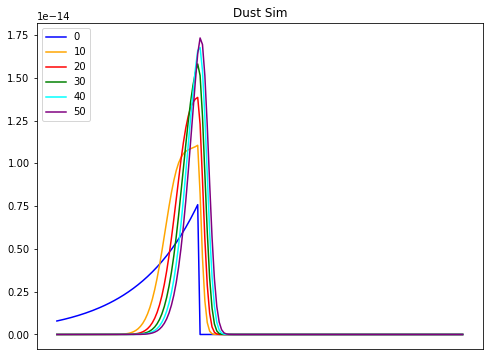

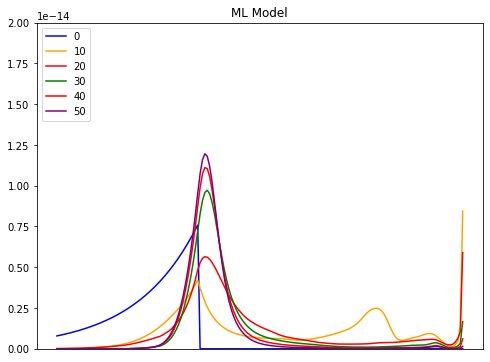

In [218]:
evaluate_preds_with_sim(9219)
#evaluate_preds_with_sim(1021)
#evaluate_preds_with_sim(9816)
#evaluate_preds_with_sim(2801)


In [ ]:
!jupyter nbconvert --to-html "Random Forest Run Models.ipynb"